## **1 - Importing Libraries & Utilities**

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output
from time import sleep, perf_counter
from datetime import timedelta
from google.colab import files, drive
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
!pip install lightgbm==3.3.5
clear_output()
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials, space_eval

In [3]:
drive.mount('/content/drive')
path_files = '/content/drive/MyDrive/2023_DSMP_Project/Merged Datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2 - Uploading Required Data File**

In [4]:
#data = pd.read_csv(path_files+'/'+'MLM_Alberta_EP_Daily.csv', encoding='latin-1')
data = pd.read_csv(path_files+'/'+'MLM_Alberta_EP_Daily_Hum.txt', sep='\t', encoding='latin-1')
data['Time'] = pd.to_datetime(data['Time'])
#
data['End-Use Demand (PetaJoules)'] = data['End-Use Demand (PetaJoules)']*277.778/365
data['GHG Emisions (KTons_CO2_Equivalent)'] = data['GHG Emisions (KTons_CO2_Equivalent)']*1000/365
data.rename(columns = {'End-Use Demand (PetaJoules)':'Daily End-Use Demand (GWh)', 'GHG Emisions (KTons_CO2_Equivalent)':'Daily GHG Emisions (Tons_CO2_Equivalent)'}, inplace = True)
#
data['Price (CAD Cents/KWh)'] = 100*data['Price (CAD $/KWh)']
del data['Price (CAD $/KWh)']

data.drop(columns=['Temp_Avg (°F)', 'Hum_Avg (%)'], axis=1, inplace=True) #,	'Hum_Min (%)'
#
print('data_shape =', data.shape)
data.head(5)

data_shape = (175248, 10)


,Time,Sources,Sector,Daily End-Use Demand (GWh),Daily GHG Emisions (Tons_CO2_Equivalent),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh)
0,2014-01-01,Natural Gas,Residential,29.208547,12.622502,2012904.75,12,-2,72,17.808286
1,2014-01-01,Renewable Energies_Biomass,Residential,29.208547,0.000000,2012904.75,12,-2,72,17.808286
2,2014-01-01,"Coal, Coke and Coke Oven Gas",Commercial,46.699048,20.488992,2012904.75,12,-2,72,15.947087
3,2014-01-01,"Coal, Coke and Coke Oven Gas",Industrial,132.148127,57.135345,2012904.75,12,-2,72,13.993189
4,2014-01-01,"Coal, Coke and Coke Oven Gas",Residential,29.208547,12.622502,2012904.75,12,-2,72,17.808286


data.drop_duplicates(keep='first', inplace=True, ignore_index=True)
data.shape

data.to_excel('Alberta_EP_Daily_MLM.xlsx', index= False)
files.download('Alberta_EP_Daily_MLM.xlsx')

cols_ = ['Time', 'Sector',
         'End-Use Demand (PetaJoules)', 'GHG Emmisions (KTons_CO2_Equivalent)',
         'Temp_Max (°F)', 'Temp_Min (°F)',
         'Hum_Min (%)',
         'Population', 'Real Gross Domestic Product ($2012 Millions)',
         'Price (CAD Cents/KWh)']

cols_ = ['Time',
        #'Electricity Generation - (GWh)', 'Electricity Capacity - (GWh)', => Those 2 features could be valuable but there is no indication from the CER with regards to which energy source has contirbuted to their outputs
        'Sector', 'Sources',
         'Daily End-Use Demand (GWh)', 'Daily GHG Emmisions (Tons_CO2_Equivalent)',
         'Real Gross Domestic Product ($2012 Millions)', 'Temp_Min (°F)',
         'Temp_Max (°F)', 'Price (CAD Cents/KWh)'] #

In [5]:
cols_ = [col for col in list(data.columns)]

In [6]:
df = data[cols_]
#
ds = df.copy()
df.head(5)

,Time,Sources,Sector,Daily End-Use Demand (GWh),Daily GHG Emisions (Tons_CO2_Equivalent),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh)
0,2014-01-01,Natural Gas,Residential,29.208547,12.622502,2012904.75,12,-2,72,17.808286
1,2014-01-01,Renewable Energies_Biomass,Residential,29.208547,0.000000,2012904.75,12,-2,72,17.808286
2,2014-01-01,"Coal, Coke and Coke Oven Gas",Commercial,46.699048,20.488992,2012904.75,12,-2,72,15.947087
3,2014-01-01,"Coal, Coke and Coke Oven Gas",Industrial,132.148127,57.135345,2012904.75,12,-2,72,13.993189
4,2014-01-01,"Coal, Coke and Coke Oven Gas",Residential,29.208547,12.622502,2012904.75,12,-2,72,17.808286


In [7]:
del df['Daily GHG Emisions (Tons_CO2_Equivalent)']
del ds['Daily GHG Emisions (Tons_CO2_Equivalent)']

## **3 - Pre-Processing**

### **3.1 - Removing Outliers**

In [8]:
thres = 0.95
print(df.shape)
for col in [#'Daily GHG Emisions (Tons_CO2_Equivalent)',
            'Real Gross Domestic Product ($2012 Millions)',
            'Temp_Max (°F)', 'Temp_Min (°F)', #'Hum_Avg (%)',
            'Price (CAD Cents/KWh)']:
  print(col)
  upper_limit = df[col].quantile(thres)
  lower_limit = df[col].quantile(1-thres)
  #
  df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]
  df.reset_index(inplace = True, drop = True)
  print(df.shape)
print()
#
df.reset_index(drop=True, inplace=True)

(175248, 9)
Real Gross Domestic Product ($2012 Millions)
(166992, 9)
Temp_Max (°F)
(153264, 9)
Temp_Min (°F)
(141120, 9)
Price (CAD Cents/KWh)
(129008, 9)



### **3.2 - Encoding Catergorical Variables**

In [9]:
df.sort_values(by=['Time'], ascending=True, inplace=True)

In [10]:
df_ = df[[col for col in (df.columns) if df[col].dtype!='O']]
df_.head()

,Time,Daily End-Use Demand (GWh),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh)
0,2014-01-01,29.208547,2012904.75,12,-2,72,17.808286
26,2014-01-01,29.208547,2012904.75,12,-2,72,17.808286
27,2014-01-01,46.699048,2012904.75,12,-2,72,15.947087
28,2014-01-01,46.699048,2012904.75,12,-2,72,15.947087
29,2014-01-01,46.699048,2012904.75,12,-2,72,15.947087


In [11]:
# Create splits
X_train, X_test = df_[df_['Time']<'2022-01-01'].iloc[:,:-1], df_[df_['Time']>='2022-01-01'].iloc[:,:-1]
y_train, y_test = df_[df_['Time']<'2022-01-01'].iloc[:,-1], df_[df_['Time']>='2022-01-01'].iloc[:,-1]
print(X_train.shape)
print(X_test.shape)
np.round(X_test.shape[0]/X_train.shape[0],2)

(103328, 6)
(25680, 6)


0.25

le = LabelEncoder()
# Fit and transform the categorical data
for col in list(X_train.columns):
    if X_train[col].dtype == 'O' and 'Time' not in col:
       print(col)
       X_train[col] = le.fit_transform(X_train[col])
       X_test[col] = le.transform(X_test[col])
       #
       df_copy[col] = le.transform(df_copy[col])

## **4 - ML Modelling**

### **4.1 - Defining Search Space**

In [12]:
search_space = {}
search_space['rfr'] = hp.choice('regressor_type', [
                                            {'type': 'rfr', 'n_estimators': hp.uniformint('rfr_n_estimators', 10, 50), # This is about num of trees
                                             'max_depth': hp.uniformint('rfr_max_depth', 5, 30), 'max_features': hp.uniformint('rfr_max_features' , 10, 50),
                                             'min_samples_split': hp.uniformint('rfr_min_samples_split', 3, 30),
                                             'min_samples_leaf': hp.uniformint('rfr_min_samples_leaf', 10, 50),
                                             }
                                            ]
                         )
#
search_space['lightgbm'] = hp.choice('regressor_type', [
                                            {'type': 'lightgbm',
                                             'max_depth': hp.uniformint('lightgbm_max_depth', 5, 15), #'num_leaves': hp.uniformint('lightgbm_max_leaf_nodes' , 10, 1000),
                                             'min_data_in_leaf': hp.uniformint('lightgbm_min_data_in_leaf', 10, 100),
                                             'learning_rate': hp.choice('lightgbm_learning_rate', [0.0001, 0.001, 0.005, 0.01, 0.05]),
                                             }
                                            ]
                         )
#
search_space['xgbr'] = hp.choice('regressor_type', [
                                            {'type': 'xgbr',
                                             'max_depth': hp.uniformint('xgbr_max_depth', 6, 15), #'num_leaves': hp.uniformint('lightgbm_max_leaf_nodes' , 10, 1000),
                                             'subsample': hp.uniform('xgbr_subsample', 0.5, 1),
                                             'learning_rate': hp.uniform('xgbr_learning_rate', 0.0001, 0.05),
                                             'alpha': hp.uniform('xgbr_alpha', 0, 10),
                                             'lambda': hp.uniform('xgbr_lambda', 0, 10),
                                             'gamma': hp.uniform('xgbr_gamma', 0, 10),
                                             'min_child_weight': hp.uniform('xgbr_min_child_weight', 0, 10),
                                             #'booster': hp.choice('xgbr_booster', ['gbtree', 'dart']),
                                             #'eta': hp.uniform('xgbr_eta', 0.01, 1),
                                             }
                                            ]
                         )

### **4.2 - Defining Objective Function**

In [13]:
def objective(params):
  regressor_type = params['type']
  del params['type']
  if regressor_type == 'rfr':
    model = RandomForestRegressor(**params)
  elif regressor_type == 'gbr':
    model = GradientBoostingRegressor(**params)
  elif regressor_type == 'lightgbm':
    model = LGBMRegressor(**params)
    model.max_depth = params['max_depth']
    model.num_leaves = 2**params['max_depth']-20
  else:
    model = XGBRegressor(**params)
  #
  #Pipe_ = Pipeline(steps=[("preprocessor", preprocessor), ('sc', MaxAbsScaler()), ("regressor", model)])
  #
  # y[:,0] => BHP (barg)
  # y[:,1] => BHT (°C)
  mae = abs(cross_val_score(model, X_train.iloc[:,1:].values, y_train.values, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1, error_score = 0.99)).mean()
  model.fit(X_train.iloc[:,1:].values, y_train.values)
  yhat = model.predict(X_test.iloc[:,1:].values)
  mae_ = mean_absolute_error(y_test.values, yhat)
  clear_output()
    # Because fmin() tries to minimize the objective, this function must return the negative accuracy.
  return {'loss': mae_, 'status': STATUS_OK}

np.array(df.iloc[:,:-1])

### **4.3 - Optimazion and HP Finetuning**

In [14]:
def get_best_params(model_):
    start = perf_counter()
    trials = Trials()
    # Hyperopts Trials() records all the model and run artifacts.
    best_params = {}
    print(model_)
    best_regressor = fmin(objective, space = search_space[model_], algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.default_rng())
    # Fmin will call the objective function with selective param set.
    best_params = space_eval(search_space[model_], best_regressor)
    duration_ = (perf_counter()-start)/60
    return best_params, duration_

### **4.4 - Implementing HyperOpt Optimazion on Different Algorithms**

In [15]:
models_ = ['lrm','rfr', 'lightgbm', 'xgbr']
for model_ in models_:
  print(model_)
params_ = {}
duration = []

lrm
rfr
lightgbm
xgbr


In [16]:
start = perf_counter()
model_ = LinearRegression()
mae = abs(cross_val_score(model_, X_train.iloc[:,1:].values, y_train.values, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1, error_score = 0.99)).mean()
model_.fit(X_train.iloc[:,1:].values, y_train.values)
yhat = model_.predict(X_test.iloc[:,1:].values)
mae_ = mean_absolute_error(y_test.values, yhat)
#
duration_ = (perf_counter()-start)/60
duration.append(np.round(duration_,1))
duration_

0.03242901566663932

# Random Forests Regressor
best_params, duration_ = get_best_params(models_[0])
print('Duration = %.1f' %(np.round(duration_, 1)))
duration.append(np.round(duration_, 1))
del best_params['type']
params_['rfr'] = best_params
best_params

In [17]:
duration.append(12.8)
params_['rfr'] = {'max_depth': 22, 'max_features': 48,
                  'min_samples_leaf': 10, 'min_samples_split': 25,
                  'n_estimators': 23}

# Light GBM
best_params, duration_ = get_best_params(models_[1])
print('Duration = %.1f' %(np.round(duration_, 1)))
duration.append(np.round(duration_, 1))
del best_params['type']
params_['lightgbm'] = best_params
best_params

In [18]:
duration.append(12.5)
params_['lightgbm'] = {'learning_rate': 0.05, 'max_depth': 14, 'min_data_in_leaf': 12}

# XGBOOST
best_params, duration_ = get_best_params(models_[-1])
print('Duration = %.1f' %(np.round(duration_, 1)))
duration.append(np.round(duration_, 1))
del best_params['type']
params_['xgbr'] = best_params
best_params

In [19]:
duration.append(4.2)
params_['xgbr'] = {'alpha': 1.309136151558377, 'gamma': 0.5716942264071462,
                   'lambda': 5.445185841842891, 'learning_rate': 0.04712499967396863,
                   'max_depth': 14, 'min_child_weight': 2.75290250925578,
                   'subsample': 0.951084704385535}

### **4.5 - Models' Performance using Fine-Tuned HyperParameters**

#### ***4.5.1 - Function - Get Model & Hyperparameters***

In [20]:
def get_model_params(regressor_type):
    if regressor_type == 'rfr':
        params = params_[regressor_type]
        model = RandomForestRegressor(**params)
    elif regressor_type == 'xgbr':
        params = params_[regressor_type]
        model = XGBRegressor(**params) #model = GradientBoostingRegressor(**params)
    elif regressor_type == 'lightgbm':
        params = params_[regressor_type]
        model = LGBMRegressor(**params)
        model.max_depth = params['max_depth']
        model.num_leaves = 2**params['max_depth']-20
    #elif regressor_type == 'gbr':
    #    params = params_['xgbr']
    #    model = GradientBoostingRegressor(**params)
    return model

#### ***4.5.2 - Models's Performance - Metrics***

In [21]:
mae_train = []
mae_test = []
mse_train = []
mse_test = []
r2_score_train = []
r2_score_test = []
std_ = []

model ====> lrm
mae_ = 1.11 CAD Cents/KWh


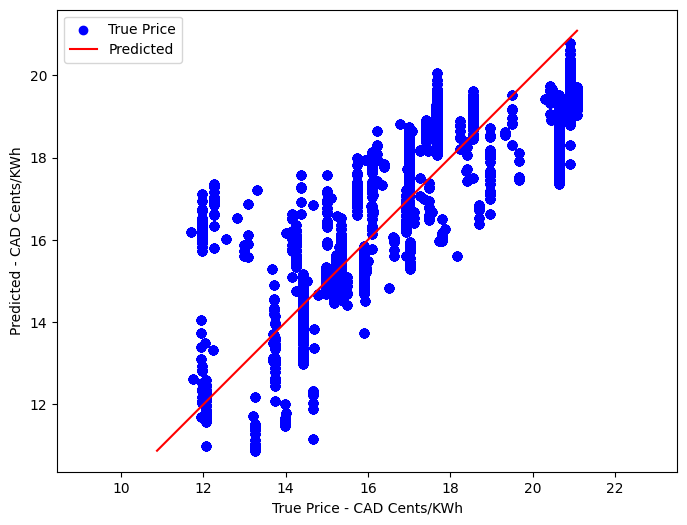

------------------------------------------------
model ====> rfr
mae_ = 0.02 CAD Cents/KWh


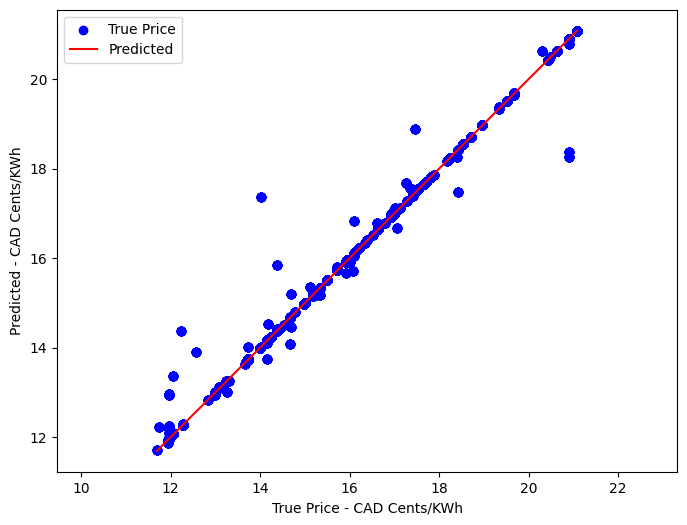

------------------------------------------------
model ====> lightgbm
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
mae_ = 0.03 CAD Cents/KWh


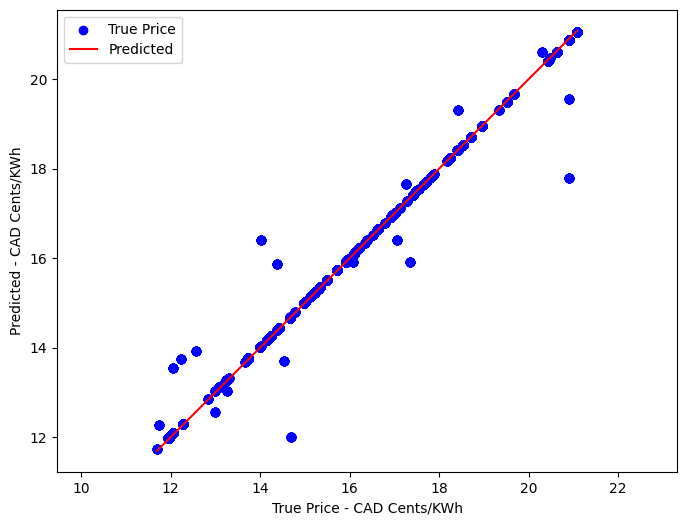

------------------------------------------------
model ====> xgbr
mae_ = 0.04 CAD Cents/KWh


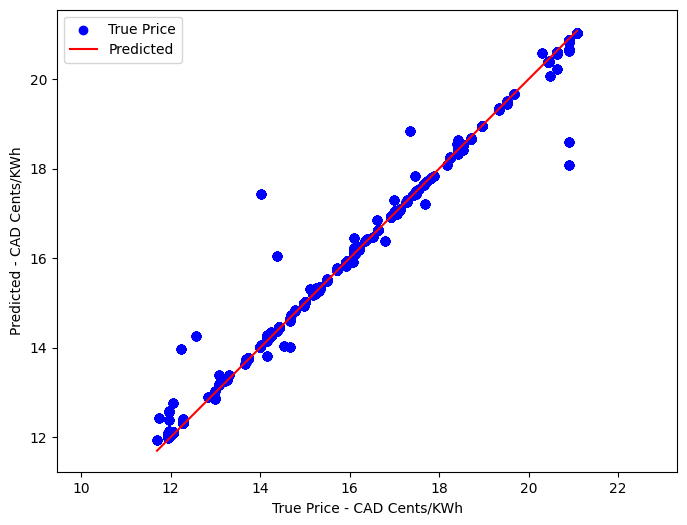

------------------------------------------------


In [22]:
for model_ in models_[0:]:
    print('model ====> %s' %(model_))
    start = perf_counter()
    if model_ != 'lrm':
      model = get_model_params(model_)
    else:
      model = LinearRegression()
    model.fit(X_train.iloc[:,1:].values, y_train.values)
    #
    pred_train = model.predict(X_train.iloc[:,1:].values)
    mae_train.append(np.round(mean_absolute_error(y_train.values, pred_train), 4))
    mse_train.append(np.round(mean_squared_error(y_train.values, pred_train), 4))
    r2_score_train.append(np.round(model.score(X_train.iloc[:,1:].values, y_train.values), 4))
    #
    pred = model.predict(X_test.iloc[:,1:].values)
    #
    #pred = scal_.inverse_transform(pred_sc.reshape(-1, 1))
    print('mae_ = %.2f CAD Cents/KWh' %(mean_absolute_error(y_test, pred)))
    mae_test.append(np.round(mean_absolute_error(y_test.values, pred), 4))
    mse_test.append(np.round(mean_squared_error(y_test.values, pred), 4))
    r2_score_test.append(np.round(model.score(X_test.iloc[:,1:].values, y_test.values), 4)) # r2_score
    std_.append((y_test.values- pred).std())
    #
    plt.figure(figsize = (8,6))
    plt.scatter(y_test, pred, c = 'blue')
    p1 = max(max(pred), max(y_test))
    p2 = min(min(pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'r-')
    plt.xlabel('True Price - CAD Cents/KWh', fontsize = 10)
    plt.ylabel('Predicted - CAD Cents/KWh', fontsize = 10)
    plt.legend(['True Price', 'Predicted'])
    plt.xlim(0, 1)
    plt.axis('equal')
    plt.show()
    print('------------------------------------------------')

### **4.5 - Models' Metrics - comparison**

In [23]:
duration

[0.0, 12.8, 12.5, 4.2]

In [24]:
cols_met = ['Duration_HP_Optim (mins)', 'MAE_train', 'MAE_test', 'MSE_train', 'MSE_test', 'R²_train', 'R²_test', 'Error_Std_Dev']
#
metrics_ = pd.DataFrame(np.column_stack((duration, mae_train, mae_test, mse_train, mse_test, r2_score_train, r2_score_test, std_)),
                        columns = cols_met, index = models_)
metrics_
# RMSE, RMSLE, MAPE

,Duration_HP_Optim (mins),MAE_train,MAE_test,MSE_train,MSE_test,R²_train,R²_test,Error_Std_Dev
lrm,0.0,1.0963,1.1150,1.9603,2.0426,0.7029,0.6846,1.428975
rfr,12.8,0.0022,0.0184,0.0005,0.0273,0.9999,0.9958,0.165139
lightgbm,12.5,0.0125,0.0274,0.0002,0.0285,1.0000,0.9956,0.168772
xgbr,4.2,0.0226,0.0362,0.0012,0.0258,0.9998,0.9960,0.160677


model_ = 'lightgbm'
model = get_model_params(model_)
model.fit(X_train.iloc[:,1:].values, y_train.values)
pred = model.predict(X_test.iloc[:,1:].values)
clear_output()
#
temp = pd.DataFrame()
temp['Actual_Price (CAD Cents/KWh)'] = y_test
temp['Predicted_Price (CAD Cents/KWh)'] = pred
#
width = 10
height = 6
sns.set(rc = {'figure.figsize':(width,height)})
sns.regplot(data=temp, x='Actual_Price (CAD Cents/KWh)', y='Predicted_Price (CAD Cents/KWh)')
sns.set_style("darkgrid")

sns.set_style("whitegrid")

## **5 - Visualization - Real vs Predicted**

### **5.1 - Data Preparation**

In [25]:
df.head(5)

,Time,Sources,Sector,Daily End-Use Demand (GWh),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh)
0,2014-01-01,Natural Gas,Residential,29.208547,2012904.75,12,-2,72,17.808286
26,2014-01-01,Renewable Energies_Biomass,Residential,29.208547,2012904.75,12,-2,72,17.808286
27,2014-01-01,Natural Gas,Commercial,46.699048,2012904.75,12,-2,72,15.947087
28,2014-01-01,Renewable Energies_Biomass,Commercial,46.699048,2012904.75,12,-2,72,15.947087
29,2014-01-01,Renewable Energies_Biomass,Commercial,46.699048,2012904.75,12,-2,72,15.947087


save_path = "/content/drive/MyDrive/2023_DSMP_Project/WebApp - StreamLit"
df.to_csv(save_path + '/' + 'df_Hum.csv', index=False)

for col in list(df_.columns):
    if df_[col].dtype == 'O' and 'Time' not in col:
       print(col)
       le = LabelEncoder()
       le.fit(X_train[col].unique())
       df_[col] = le.transform(df_[col])

### **5.2 - Inferring Predictions**

In [26]:
model_ = 'rfr'
model = get_model_params(model_)
model.fit(X_train.iloc[:,1:].values, y_train.values)
clear_output()

In [27]:
ds['Price_Pred (CAD Cents/KWh)'] = model.predict(ds.iloc[:,3:-1].values)
#df_['Sector'] = le.inverse_transform(df_['Sector'])
#17.802393
ds.head(5)

,Time,Sources,Sector,Daily End-Use Demand (GWh),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh),Price_Pred (CAD Cents/KWh)
0,2014-01-01,Natural Gas,Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286
1,2014-01-01,Renewable Energies_Biomass,Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286
2,2014-01-01,"Coal, Coke and Coke Oven Gas",Commercial,46.699048,2012904.75,12,-2,72,15.947087,15.947087
3,2014-01-01,"Coal, Coke and Coke Oven Gas",Industrial,132.148127,2012904.75,12,-2,72,13.993189,13.993189
4,2014-01-01,"Coal, Coke and Coke Oven Gas",Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286


df.to_excel('df_pred.xlsx', index = False)
files.download('df_pred.xlsx')

### **5.3 - Visualization - Real Prices vs Predicted Prices**

data = pd.concat([data, df_['Price_Pred (CAD Cents/KWh)']], axis=1)
#
data = data[(data['Sources'] == 'Natural Gas') & (data['Interchange Flows'] == 'Interprovincial In-Flows')]
data.reset_index(drop=True, inplace=True)
data.head()

plt.figure(figsize=(10,6))
plt.scatter(df_['Price (CAD Cents/KWh)'], df_['Price_Pred (CAD Cents/KWh)'], s=13)
plt.xlim([5, 25])
plt.ylim([5, 25])
plt.grid()
plt.xlabel("Price - Actual")
plt.ylabel('Price - Predicted')
plt.show()

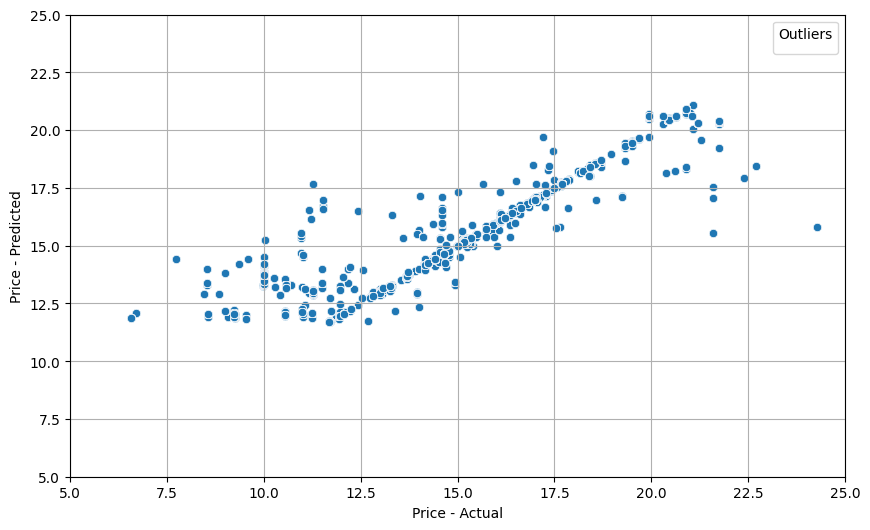

In [28]:
plt.figure(figsize=(10,6))
is_outlier = (ds['Price (CAD Cents/KWh)']<lower_limit) | (ds['Price (CAD Cents/KWh)']>upper_limit)
#
sns.scatterplot(data=ds, x='Price (CAD Cents/KWh)', y='Price_Pred (CAD Cents/KWh)')#, hue=is_outlier)#, size=13)
plt.xlim([5, 25])
plt.ylim([5, 25])
plt.grid()
plt.xlabel("Price - Actual")
plt.ylabel('Price - Predicted')
#plt.legend(labels=['False', 'True'], title='Outliers', markerfirst=True)
plt.legend(title='Outliers')
plt.show()

#### *Function - Generate Plots*

In [29]:
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates

In [30]:
def plot_price_vs_predicted(x, y, z, sector_):
  plt.figure(figsize = (14,6))
  ax = plt.gca()
  # Plot both the curves simultaneously
  plt.plot(x, y, color='b', label = 'Real')
  plt.plot(x, z, color = 'orange', label = 'Predicted')
  #
  plt.axhline(y = upper_limit, color = 'r', linestyle = 'dashed', label = "Outliers' Lower Limit")
  plt.axhline(y = lower_limit, color = 'r', linestyle = 'dashdot', label = "Outliers' Upper Limit")

  # Naming the x-axis, y-axis and the whole graph
  ax.xaxis.set_major_locator(mdates.YearLocator(1, month = 12))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  plt.gcf().autofmt_xdate()
  plt.xlabel("Timestamp")
  plt.ylabel('Electricity Price (CAD Cents/KWh)')
  plt.legend()
  plt.title(sector_ + ' Sector - Electricity Prices')
  #plt.ylim([0, 40])
  plt.grid()
  plt.show()

#### **5.3.1 - Generate Plots - All Sectors**

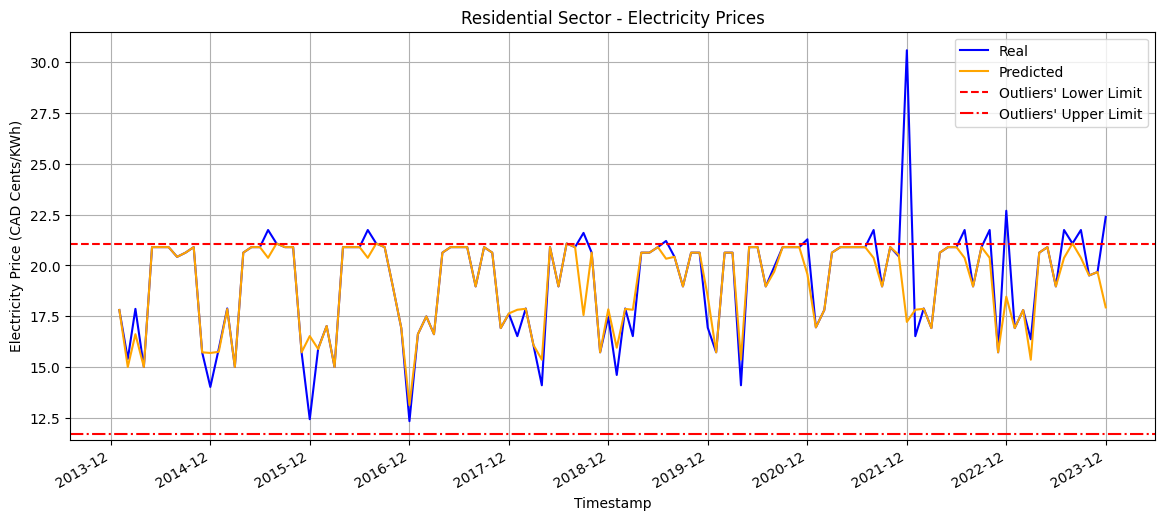


------------------------------------------------------------------------------------------



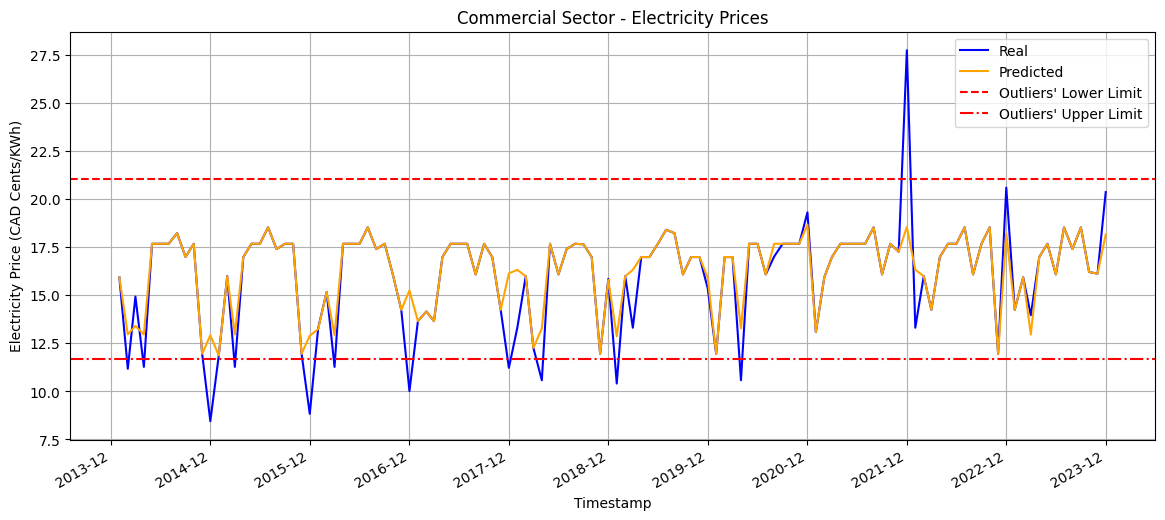


------------------------------------------------------------------------------------------



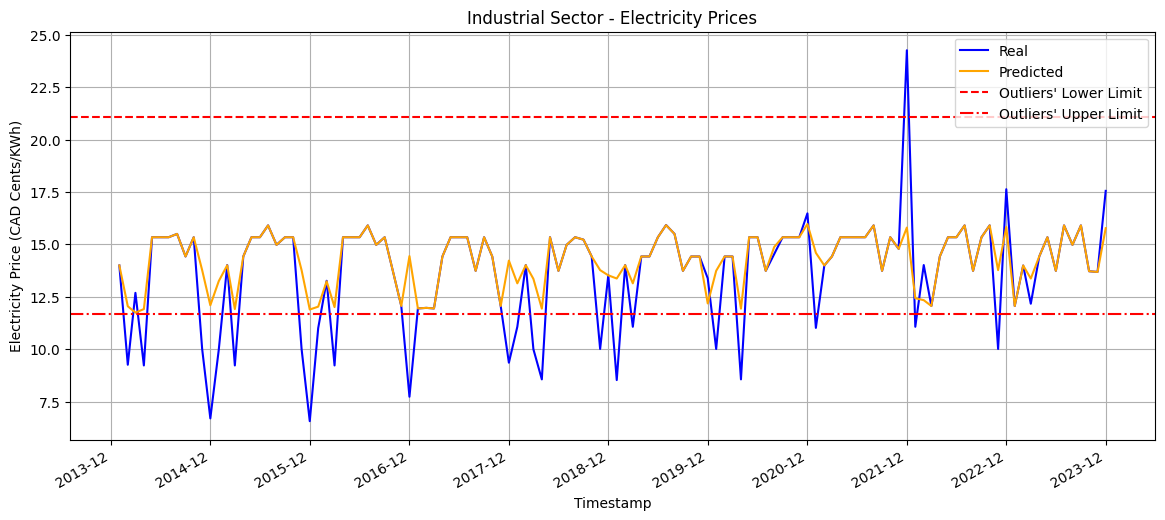


------------------------------------------------------------------------------------------



In [31]:
for sector_ in list(ds['Sector'].unique()):
  #print(sector_)
  temp = ds[ds['Sector'] == sector_]
  temp.sort_index(axis=0, ascending=True, inplace=True)
  #
  time_stamp = []
  price_ = []
  pred_price = []
  start_date = data['Time'][0]
  date_ = start_date
  #
  while str(date_).split(' ')[0] < '2024-01-01':
    if str(date_).split(' ')[0].split('-')[-1] == '01':
      time_stamp.append(date_)
      price_.append(temp[temp['Time'] == str(date_)][['Price (CAD Cents/KWh)']].iloc[0,0])
      pred_price.append(temp[temp['Time'] == str(date_)][['Price_Pred (CAD Cents/KWh)']].iloc[0,0])
    #
    date_ = date_ + relativedelta(months =1)
  plot_price_vs_predicted(time_stamp, price_, pred_price, sector_)
  print()
  print('------------------------------------------------------------------------------------------')
  print()

### **5.4 - Saving Model**

In [32]:
ds.head(5)

,Time,Sources,Sector,Daily End-Use Demand (GWh),Real Gross Domestic Product ($2012 Millions),Temp_Max (°F),Temp_Min (°F),Hum_Min (%),Price (CAD Cents/KWh),Price_Pred (CAD Cents/KWh)
0,2014-01-01,Natural Gas,Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286
1,2014-01-01,Renewable Energies_Biomass,Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286
2,2014-01-01,"Coal, Coke and Coke Oven Gas",Commercial,46.699048,2012904.75,12,-2,72,15.947087,15.947087
3,2014-01-01,"Coal, Coke and Coke Oven Gas",Industrial,132.148127,2012904.75,12,-2,72,13.993189,13.993189
4,2014-01-01,"Coal, Coke and Coke Oven Gas",Residential,29.208547,2012904.75,12,-2,72,17.808286,17.808286


!pip install joblib
clear_output()
import joblib
#
save_path = "/content/drive/MyDrive/2023_DSMP_Project/WebApp - StreamLit"
joblib.dump(model, save_path + '/' + model_+'_model_Hum.sav')

## **6 - ML Explainability**

### **6.1 - ML EXplainability - Shap**

In [33]:
# great resource: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
!pip install shap
clear_output()
from shap import TreeExplainer, summary_plot
explainer = TreeExplainer(model)
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test.iloc[:,1:])
features_name = list(ds.columns)[3:-2]

#### **6.1.1 - Summary Plots**

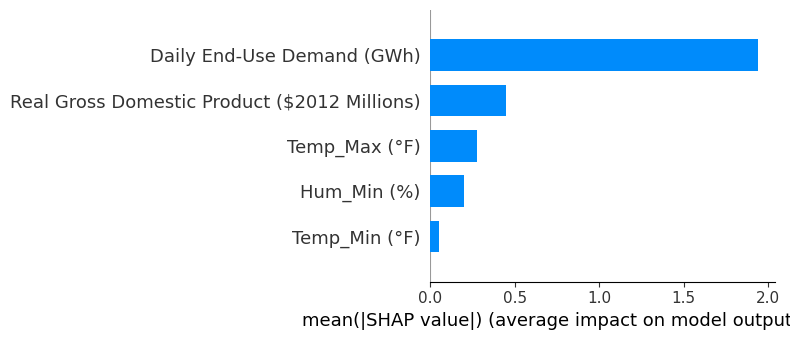

In [34]:
summary_plot(shap_values, X_test.iloc[:,1:], feature_names = features_name, plot_type="bar")

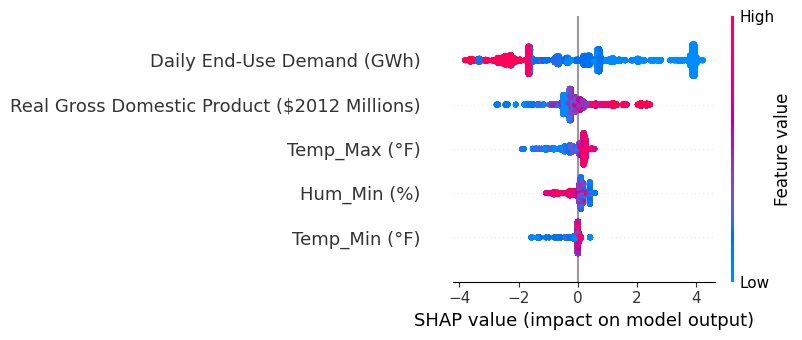

In [35]:
summary_plot(shap_values, X_test.iloc[:,1:], feature_names = features_name)

#### **6.1.2 - Waterfall Plot**

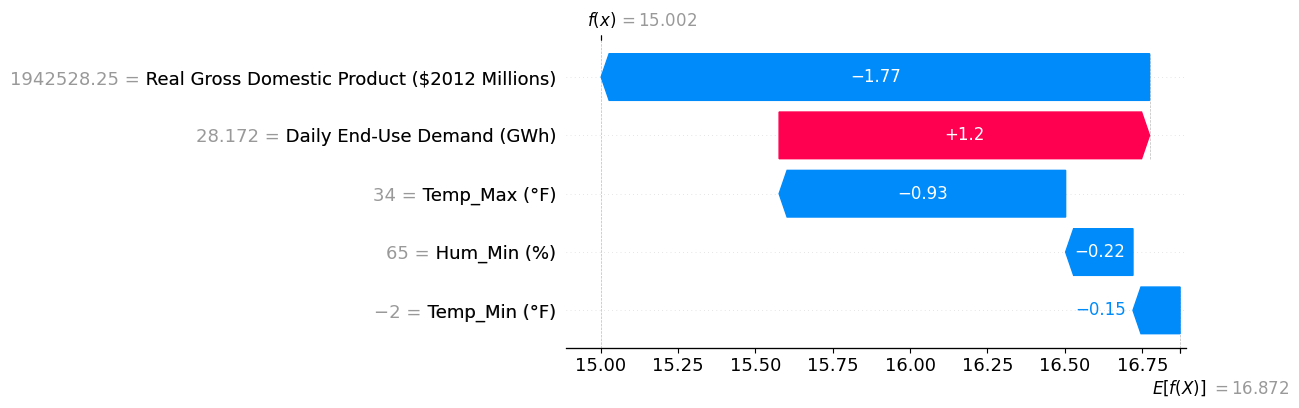

In [36]:
from shap import Explainer, plots
explainer_ = Explainer(model)
shap_values_ = explainer(X_test.iloc[:,1:])
plots.waterfall(shap_values_[13])

### **6.2 - ML EXplainability - eli5**

In [37]:
!pip install eli5
clear_output()
import eli5 as eli

In [38]:
eli.explain_weights(model, feature_names=list(ds.columns)[3:-2])

Weight,Feature
0.8143 ± 0.0070,Daily End-Use Demand (GWh)
0.1107 ± 0.0099,Real Gross Domestic Product ($2012 Millions)
0.0324 ± 0.0178,Hum_Min (%)
0.0322 ± 0.0116,Temp_Max (°F)
0.0105 ± 0.0073,Temp_Min (°F)


In [39]:
#plt.figure(figsize=(10,5))
pred_13 = eli.show_prediction(model , np.array(ds.iloc[13,3:-2]), feature_names=list(ds.columns)[3:-2])
result_13 = pd.read_html(pred_13.data)[0]
result_13

,Contribution?,Feature
0,16.872,<BIAS>
1,-0.059,Temp_Max (°F)
2,-0.664,Daily End-Use Demand (GWh)
3,-0.965,Hum_Min (%)
4,-1.191,Real Gross Domestic Product ($2012 Millions)


In [40]:
pred_20 = eli.show_prediction(model , np.array(ds.iloc[20,3:-2]), feature_names=list(ds.columns)[3:-2])
result = pd.read_html(pred_20.data)[0]
result

,Contribution?,Feature
0,16.872,<BIAS>
1,-0.059,Temp_Max (°F)
2,-0.664,Daily End-Use Demand (GWh)
3,-0.965,Hum_Min (%)
4,-1.191,Real Gross Domestic Product ($2012 Millions)
